# Modelling a time series with windowing

The dataset used is the [weather time series dataset](https://www.bgc-jena.mpg.de/wetter/). The data containts 14 different features concerning the weather collected every 10 minutes since the beginning of 2003. By default we use only the data from 2009 to 2016, but the rest of the data can be used by simply ammending the `origin` variable below.

The model accepts a combination of the 14 features to predict any feature for a specified window in the future.

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

TensorFlow 2.x selected.


Download and read the csv into a dataframe.

In [0]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

13574144/13568290 [==============================] - 0s 0us/step


In [0]:
df = pd.read_csv(csv_path)

The 14 features recorded can be seen below.

In [0]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [0]:
tf.random.set_seed(1) 

The model will be trained on the features listed in `features_considered` to predict the feature `predict`.

In [0]:
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']
predict = 'T (degC)'

idx_pred = features_considered.index(predict) # To map inputs to labels later
FEATURES = len(features_considered)

In [0]:
features = df[features_considered]
features.index = df['Date Time']
features.head()

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


`TRAIN` is the number of samples to use in training set.

`HISTORY` is the number of previous time steps used for prediction.

`TARGET` is how many time steps the model aims to predict.

`SAMPLE_RATE` determines how often we sample from the dataset. Since observations are taken every 10 minutes, a rate of 1 takes every 10 minute sample, a rate of 6 would take a sample every hour, etc.

In [0]:
TRAIN = 30000
HISTORY = 120
TARGET = 5
SAMPLE_RATE = 6

The `make_window_dataset` function takes in a dataset and applies a shifting window over the values using the `tf.data.Dataset.window` method. This returns a dataset of datasets, which we flatten into a single dataset using the `tf.data.Dataset.flat_map` method.

In [0]:
def make_window_dataset(ds, window_size, shift, stride):
  windows = ds.window(window_size, shift=shift, stride=stride)

  def sub_to_batch(sub):
    return sub.batch(window_size, drop_remainder=True) # Drop the smaller batches

  windows = windows.flat_map(sub_to_batch)
  return windows

We now calculate the mean and standard deviation of each feature, and normalize our data.

In [0]:
dataset = features.values
data_mean = dataset[:TRAIN].mean(axis=0) # Only training data should be used for normalization
data_std = dataset[:TRAIN].std(axis=0)

In [0]:
dataset = (dataset-data_mean)/data_std

In [0]:
if FEATURES == 1:
  # Add dimension if only a single feature used -- for passing to LSTM layer
   dataset = np.reshape(dataset, (dataset.shape[0], 1))

train = dataset[:TRAIN] # train split
val = dataset[TRAIN:] # validation split

Build the training and validation datasets using the `tf.data.Dataset.from_tensor_slices` method.

In [0]:
train_ds = tf.data.Dataset.from_tensor_slices(train)
val_ds = tf.data.Dataset.from_tensor_slices(val)

Turn them into windowed datasets, where each element is a single window of training and prediction values. Window size = `HISTORY + TARGET`.

In [0]:
train_window = make_window_dataset(train_ds, window_size=HISTORY + TARGET, 
                                   shift = TARGET, stride=SAMPLE_RATE)

val_window = make_window_dataset(val_ds, window_size=HISTORY + TARGET, 
                                 shift = TARGET, stride=SAMPLE_RATE)

We now map the history window to the target window.

In [0]:
if FEATURES > 1:
  train_window = train_window.map(lambda window: (window[:-TARGET], window[-TARGET: , idx_pred]))
  val_window = val_window.map(lambda window: (window[:-TARGET], window[-TARGET: , idx_pred]))

else:
  train_window = train_window.map(lambda window: (window[:-TARGET], window[-TARGET:]))
  val_window = val_window.map(lambda window: (window[:-TARGET], window[-TARGET:]))

Shuffle and batch the training and validation data. Cache to prevent reloading after initial iteration.

In [0]:
train_window = train_window.cache().shuffle(10000).batch(256).repeat() # dataset repeats indefinately 
val_window = val_window.batch(256).repeat()

Build the model for prediction, it consists of LSTM layers followed by fully connected layers where the final output is the target window size.

In [0]:
def build_model(input_shape, target_size, units = 8, layer_count = 1, dense_count = 1, drop_rate = 0.2):

  model = tf.keras.Sequential()
  model.add(tf.keras.layers.LSTM(units, input_shape = input_shape, 
                                 return_sequences = True if layer_count > 1 else False)) # Don't want seq if passing directly to Dense
  for i in range(layer_count-1):
    model.add(tf.keras.layers.LSTM(units//(2**(i+1)), activation='relu'))
  
  if dense_count > 1:
    for _ in range(dense_count-1):
      model.add(tf.keras.layers.Dense(units))
      model.add(tf.keras.layers.Dropout(drop_rate))

  model.add(tf.keras.layers.Dense(target_size))

  return model

In [0]:
model = build_model(input_shape = (HISTORY, FEATURES), target_size = TARGET, 
                    units = 32, layer_count=2, dense_count=2)

We are trying to predict continuous values over a time period, so we use the mean average error provided by `tf.keras.losses.MAE` as the loss function.

In [0]:
model.compile(optimizer=tf.keras.optimizers.Adam(5e-3), loss='mae')

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 120, 32)           4608      
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense (Dense)                (None, 32)                544       
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 165       
Total params: 8,453
Trainable params: 8,453
Non-trainable params: 0
_________________________________________________________________


We now train the model. An early stopping callback is used to stop the model training once validation loss is no longer decreasing. 

In [0]:
EPOCHS = 10
EPOCH_STEPS = 200 # steps per epoch through our repeated dataset

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(train_window, epochs = EPOCHS, steps_per_epoch = EPOCH_STEPS,
                      validation_data = val_window, validation_steps = 50,
                    callbacks = [early_stop])

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 45s 226ms/step - loss: 0.3014 - val_loss: 0.1652
Epoch 2/10
200/200 [==============================] - 40s 200ms/step - loss: 0.1746 - val_loss: 0.1482
Epoch 3/10
200/200 [==============================] - 40s 202ms/step - loss: 0.1591 - val_loss: 0.1378
Epoch 4/10
200/200 [==============================] - 41s 203ms/step - loss: 0.1555 - val_loss: 0.1442
Epoch 5/10
200/200 [==============================] - 40s 202ms/step - loss: 0.1489 - val_loss: 0.1315
Epoch 6/10
200/200 [==============================] - 41s 204ms/step - loss: 0.1475 - val_loss: 0.1395
Epoch 7/10
200/200 [==============================] - 40s 202ms/step - loss: 0.1451 - val_loss: 0.1373
Epoch 8/10
200/200 [==============================] - 40s 202ms/step - loss: 0.1431 - val_loss: 0.1359


Function to plot the previous time window together with the real target window and our predicted target window.

In [0]:
def plot_data(history, true_future, prediction):

  plt.figure(figsize=(12, 6))

  num_in = list(range(-len(history),0))

  try:
    num_out = len(true_future)
  except TypeError:
    num_out = true_future

  try:
    plt.plot(num_in, np.array(history[:, idx_pred]), label='History')
  except IndexError:
    plt.plot(num_in, np.array(history[:]), label='History')
  
  plt.plot(np.arange(num_out), np.array(true_future), 'bo', label='True')

  if prediction.any():
    plt.plot(np.arange(num_out), np.array(prediction), 'ro', label='Predicted')

  plt.legend(loc='upper left')
  plt.show()

Display plots for some of the validation samples. By default blue is the True values, red is the predicted values.

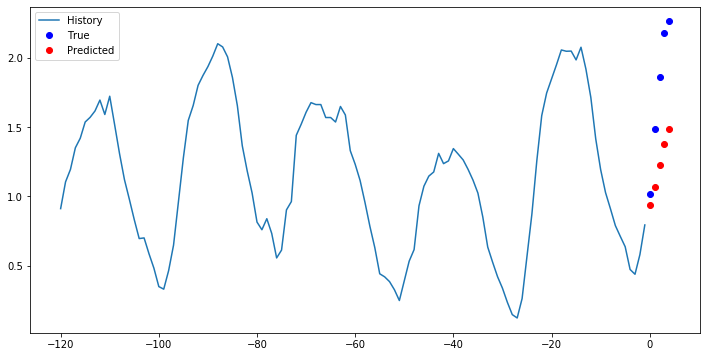

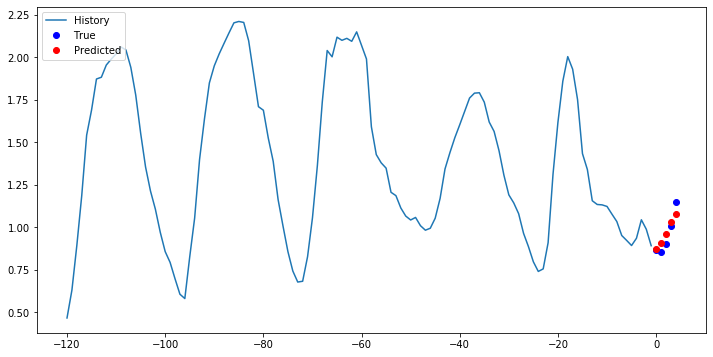

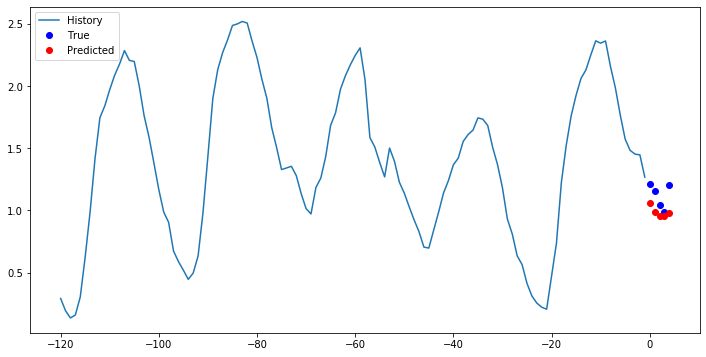

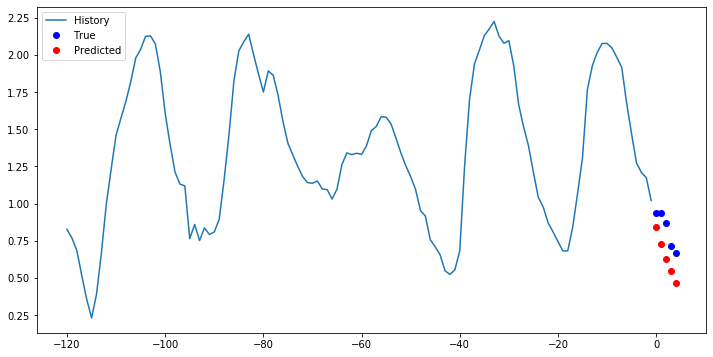

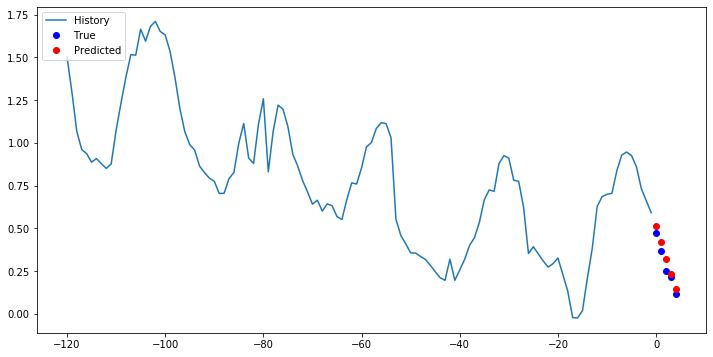

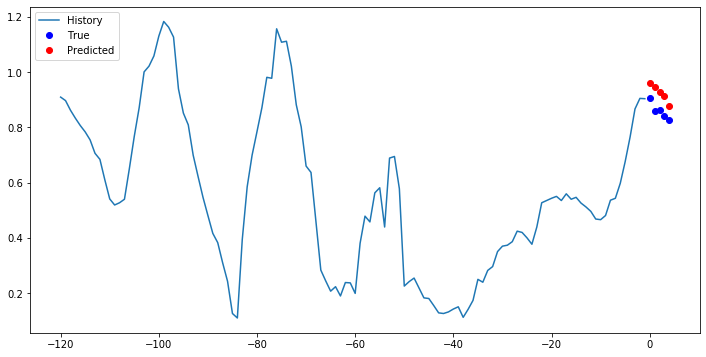

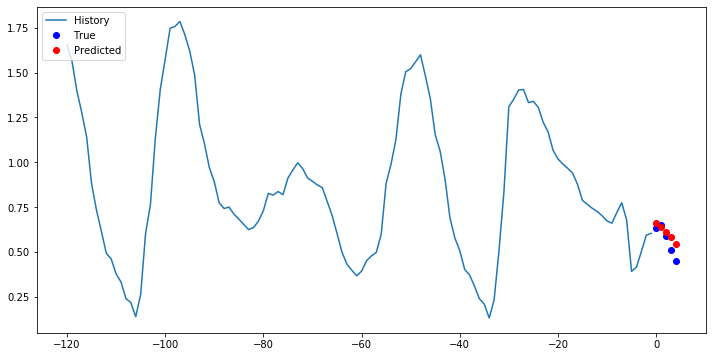

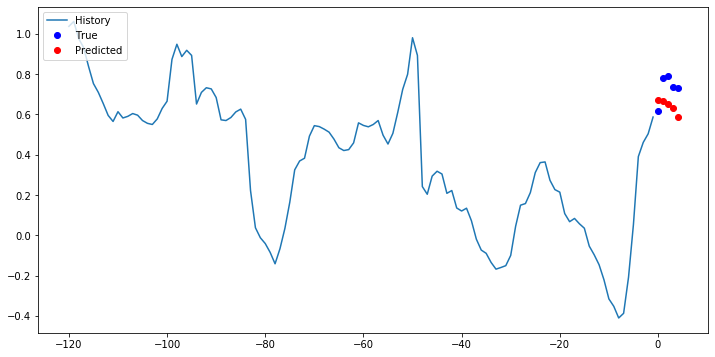

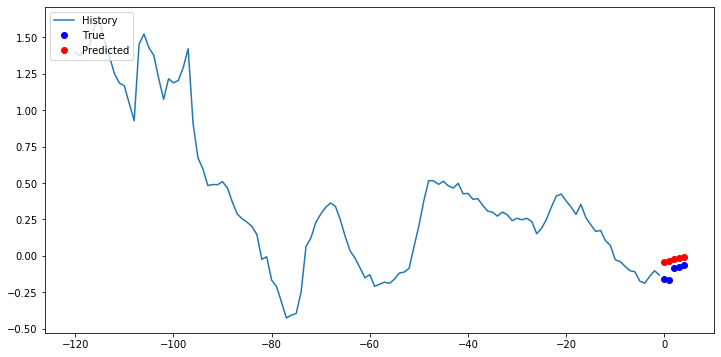

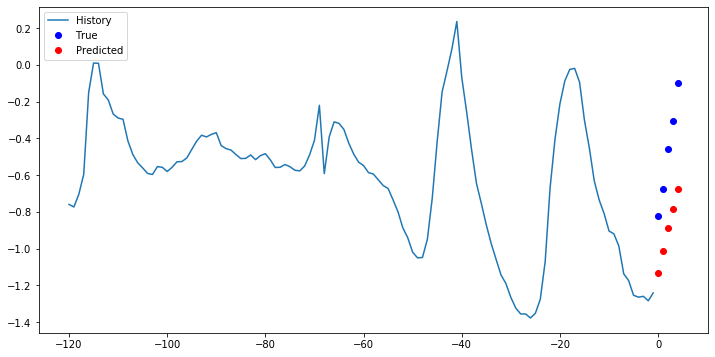

In [0]:
for x, y in val_window.take(10):
  plot_data(x[0].numpy(), y[0].numpy(), model.predict(x)[0])